# POS Tagging
This examples uses a simple LSTM on brown corpus for POS tagging.

In [ ]:
!git clone https://github.com/HLR/DomiKnowS.git
%cd DomiKnowS
!git checkout origin/Tasks
!pip install DomiKnowS

import logging
logging.basicConfig(level=logging.INFO)

import __main__
__main__.__file__="POS_tagging.py"
%cd POS_tagging

# Meta Aruguments
First we have to define the meta arguments. Here we set the cuda we want to use and the number of maximum epochs we want to train our model.

cuda_number: the gpu number that we intend to use

epoch: number of epochs that we want to train the model

learning_rate: the learning rate of the model

samplenum=1000: the number of sentences that we want to use

embedding_dim: the size of embedding for each token

hidden_dim: size of the hidden layer of the LSTM

top_pos: the top most frequent POS that we want to use. every other POS will be put in the "other" cathegory

max_sentence_length: maximom size of a sentence that is allowed

In [ ]:
import torch
from torch.optim import SGD
from domiknows.program import SolverPOIProgram
from domiknows.graph import Graph, Concept, EnumConcept, Relation
from domiknows.sensor.pytorch.sensors import ReaderSensor, JointSensor, FunctionalSensor
from domiknows.sensor.pytorch.learners import ModuleLearner
from domiknows.program.loss import NBCrossEntropyLoss
from domiknows.program.metric import MacroAverageTracker, PRF1Tracker, DatanodeCMMetric
from models import POSLSTM, HeadLayer
import logging
from argparse import Namespace
from utils import LabelReader, make_words, create_reader_and_vocuabulary
import random
args = Namespace(
cuda_number=0,
epoch=5,
learning_rate=2e-3,
samplenum=1000,
embedding_dim=200,
hidden_dim=200,
top_pos=1000,
max_sentence_length=30,
)
import warnings
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)

args.device="cuda:"+str(args.cuda_number) if torch.cuda.is_available() else 'cpu'
print("device is :",args.device)


device is : cpu


# Reader
Our reader is a list of dictionaries and each dictionary has the attributes for the root node to read. We need one reader for each train, dev and test.

In [ ]:

vocabulary,tag_list,reader=create_reader_and_vocuabulary(samplenum=args.samplenum,top_pos=args.top_pos,max_sentence_length=args.max_sentence_length)

random.seed(2021)
random.shuffle(reader)
train_reader,dev_reader,test_reader=reader[:len(reader)//10*6],reader[len(reader)//10*6:len(reader)//10*8],reader[len(reader)//10*8:]

print(train_reader[0])


10 most frequent tags:  [('nn', 1846), ('in', 1455), ('at', 1171), ('.', 1114), ('jj', 830), (',', 742), ('rb', 716), ('nns', 568), ('vb', 558), ('cc', 464)]
Size of the vocabulary 3574
{'sentecne': ['He asked her severely .'], 'tags': ['pps vbd ppo rb .']}


# Graph
We reset the graph for our peace of mind and define it in the next lines.

In [ ]:
print("Graph Declaration:")

Graph.clear()
Concept.clear()
Relation.clear()

with Graph('POS_Graph') as graph:
    Sentence = Concept(name='sentence') # sentence is the root Concept of our model
    Word = Concept(name='word') # we also define a concept for every word in our sentence
    sent_word_contains, = Sentence.contains(Word) # the relationship between setnence and word on defined here that is a sentence contains some words
    Tag = Word(name="tag", ConceptClass=EnumConcept, values=tag_list) # tag is the possible label of a word



Graph Declaration:


# Visualization

The conceptual Graph is depicted in this section.

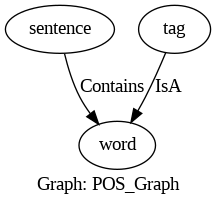

In [ ]:
from IPython.display import Image
graph.visualize("./image")
Image(filename='image.png')



# Sensors

The reader and learner Sensors are defined in the next section.

In [ ]:
# Fixed Sensors
Sentence['tokenized_text'] = ReaderSensor(keyword='sentecne')
Sentence['tokenized_pos'] = ReaderSensor(keyword='tags')
Word[sent_word_contains, "token", 'pos'] = JointSensor(Sentence['tokenized_text'],Sentence['tokenized_pos'],forward=make_words)
Word[Tag] = FunctionalSensor(sent_word_contains, "pos", forward=LabelReader(device=args.device,tag_list=tag_list), label=True)

# Trainable Sensors
Word["hidden_layer"]=ModuleLearner("token", module=POSLSTM(embedding_dim=args.embedding_dim, hidden_dim=args.hidden_dim, vocab_size=len(vocabulary),vocabulary=vocabulary,device=args.device))
Word[Tag] = ModuleLearner("hidden_layer", module=HeadLayer( hidden_dim=args.hidden_dim, target_size=len(tag_list)))

# Program

We use a simple POI program here since we have not defined any important constraint that would take advantage of IML and PD programs.

Other inputs are graph, loss function and the metric.

In [ ]:

program = SolverPOIProgram(graph,inferTypes=['local/argmax'],loss=MacroAverageTracker(NBCrossEntropyLoss()), metric=PRF1Tracker(DatanodeCMMetric('local/argmax')))

program.train(reader[:len(reader)//10*8],valid_set=reader[len(reader)//10*8:], train_epoch_num=args.epoch, Optim=lambda param: SGD(param, lr=args.learning_rate),device=args.device)
program.train(reader[:len(reader)//10*8])

word_results=[]
word_labels=[]
for pic_num, sentence in enumerate(program.populate(reader[:len(reader)//10*8], device=args.device)):
    for word in sentence.getChildDataNodes():
        word_results.append(int(torch.argmax(word.getAttribute(Tag, "local/argmax"))))
        word_labels.append(int(word.getAttribute(Tag, "label").item()))

print("Final model accuracy is :",sum([i==j for i,j in zip(word_results,word_labels)])/len(word_results))

Epoch 1 Training: 100%|██████████| 800/800 [16:16<00:00,  1.22s/it]
800it [00:46, 17.16it/s]

Final model accuracy is : 0.33900481540930977
